In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import time


In [2]:
model_path = 'mental_health_expression_model.h5'
history_acc_path = 'history_accuracy.npy'
history_val_acc_path = 'history_val_accuracy.npy'

In [3]:
model = load_model(model_path)
print("Model loaded.")


Model loaded.


In [4]:
# Load history
acc = np.load(history_acc_path)
val_acc = np.load(history_val_acc_path)

In [5]:
# Define categories (ensure matches training)
categories = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
img_size = 48

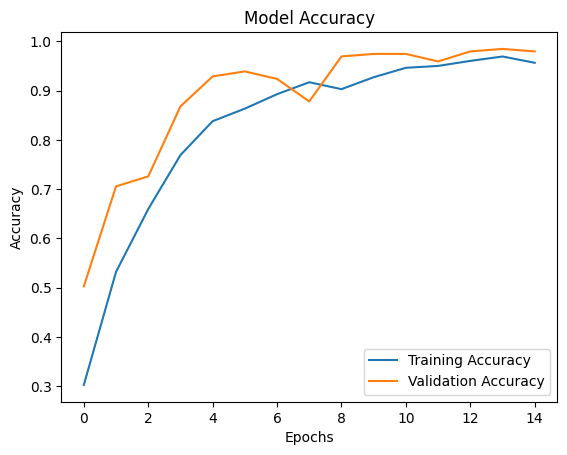

In [6]:
# Plot accuracy graph
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
# Step 4: Expression Prediction Function
def predict_expression(face_img):
    face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
    face_img = cv2.resize(face_img, (img_size, img_size))
    face_img = face_img.reshape(1, img_size, img_size, 1) / 255.0
    pred = model.predict(face_img, verbose=0)
    return categories[np.argmax(pred)]

In [8]:
# Step 5: Real-Time Video Analysis with Face Tracking
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

emotion_to_risk = {
    'angry': 'High Stress',
    'sad': 'Depression Risk',
    'happy': 'Low Risk',
    'surprise': 'Neutral',
    'fear': 'Anxiety Risk',
    'disgust': 'Stress Risk'
}

students = {}
risk_counts = {'High Stress': 0, 'Depression Risk': 0, 'Anxiety Risk': 0, 'Stress Risk': 0, 'Low Risk': 0, 'Neutral': 0, 'Unknown': 0}
next_student_id = 1

cap = cv2.VideoCapture(0)
start_time = time.time()
capture_duration = 30

while int(time.time() - start_time) < capture_duration:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        face_center = (x + w//2, y + h//2)

        matched_id = None
        for student_id, info in students.items():
            sx, sy, sw, sh = info['bbox']
            sx_center = sx + sw//2
            sy_center = sy + sh//2

            if abs(face_center[0] - sx_center) < 50 and abs(face_center[1] - sy_center) < 50:
                matched_id = student_id
                break

        if matched_id is None:
            matched_id = f"S{next_student_id}"
            next_student_id += 1
            students[matched_id] = {
                'bbox': (x, y, w, h),
                'emotion_counts': {e: 0 for e in categories},
                'risk_counts': {r: 0 for r in risk_counts.keys()},
                'total_frames': 0
            }

        students[matched_id]['bbox'] = (x, y, w, h)

        face_img = frame[y:y+h, x:x+w]
        emotion = predict_expression(face_img)
        risk = emotion_to_risk.get(emotion, 'Unknown')

        students[matched_id]['emotion_counts'][emotion] += 1
        students[matched_id]['risk_counts'][risk] += 1
        students[matched_id]['total_frames'] += 1

        risk_counts[risk] += 1

        color = (0, 255, 0) if risk == 'Low Risk' else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, f'{emotion} | {risk} | {matched_id}', (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    cv2.imshow('Mental Health Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

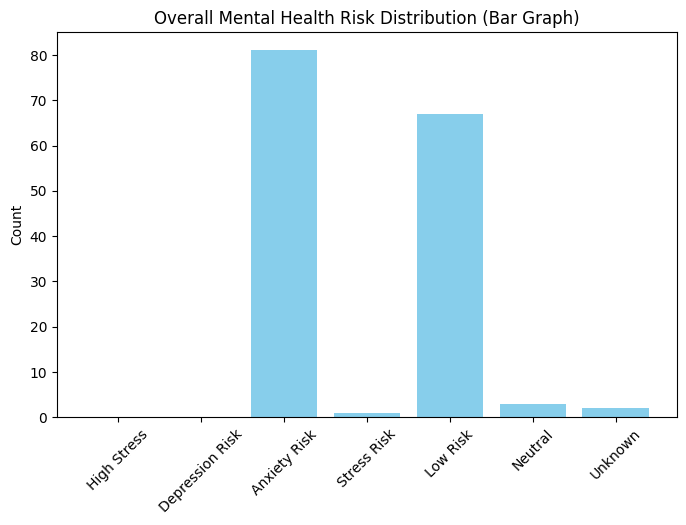

In [9]:
# Step 6: Bar Graph for Overall Risk Distribution
plt.figure(figsize=(8, 5))
plt.bar(risk_counts.keys(), risk_counts.values(), color='skyblue')
plt.title('Overall Mental Health Risk Distribution (Bar Graph)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [10]:
# Step 7: Generate Individual Student Reports, Pie Charts, and Stability per Student
report_dir = 'student_reports'
os.makedirs(report_dir, exist_ok=True)

for student_id, stats in students.items():
    total_frames = stats['total_frames']
    low_risk = stats['risk_counts'].get('Low Risk', 0)
    if total_frames == 0:
        stability = 'Unknown'
    elif low_risk / total_frames > 0.7:
        stability = 'Stable'
    elif low_risk / total_frames > 0.4:
        stability = 'Moderate'
    else:
        stability = 'Unstable'

    report_path = os.path.join(report_dir, f'{student_id}_report.txt')
    with open(report_path, 'w') as f:
        f.write(f'Student ID: {student_id}\n')
        f.write(f'Total Frames Detected: {total_frames}\n')
        f.write(f'Stability: {stability}\n\n')

        f.write('Emotion Counts:\n')
        for emotion, count in stats['emotion_counts'].items():
            f.write(f'{emotion}: {count}\n')

        f.write('\nMental Health Risk Counts:\n')
        for risk, count in stats['risk_counts'].items():
            f.write(f'{risk}: {count}\n')

    # Pie Chart for student
    plt.figure(figsize=(5, 5))
    plt.pie(stats['risk_counts'].values(), labels=stats['risk_counts'].keys(), autopct='%1.1f%%', startangle=140)
    plt.title(f'Mental Health Risk - {student_id} ({stability})')
    plt.savefig(os.path.join(report_dir, f'{student_id}_risk_piechart.png'))
    plt.close()

print(f"Reports, Pie Charts, and Stability saved in {report_dir}")

Reports, Pie Charts, and Stability saved in student_reports


In [11]:
# Step 8: Overall Classroom Stability Estimate
low_risk = risk_counts.get('Low Risk', 0)
total_faces = sum(risk_counts.values())
if total_faces == 0:
    stability = 'Unknown'
elif low_risk / total_faces > 0.7:
    stability = 'Stable'
elif low_risk / total_faces > 0.4:
    stability = 'Moderate'
else:
    stability = 'Unstable'

print(f"Overall Classroom Stability: {stability}")

Overall Classroom Stability: Moderate
